## Preamble for the revision

New version of this notebook for revising the WRR manuscript. 

Use this to generate the merged data for the GSA.

In [1]:
import seaborn as sns
#import bokeh.plotting as blt
#import bokeh.models as bmod
import matplotlib as mpl
import matplotlib.cm as cm
from statsmodels.api import formula as sm
from IPython.display import Image
import matplotlib
import matplotlib.cm as cm
from scipy.interpolate import griddata
import scipy

def standardize(x):
    '''Use on a pd.series'''
    
    mn = np.nanmean(x)
    sd = np.nanstd(x)
    
    x2 = (x-mn)/sd
    
    return x2

sns.set_style('white')

In [4]:
def process_df_wy(data):
    data.PeakSWE *= 1000. # convert m to mm
    data.SMR *= 1000. # convert m/d to mm/d
    data.MAP *= 1000. # convert m to mm
    
    data['Pmodel'] = data['PeakSWE'] + data['p'] # this is all of the precip data fed into the  model + peak swe
    data['Pex'] = data['PeakSWE'] + data['MAP'] # this is all of the precip that the model should see in liquid form + peak swe
    
    data['wb'] = data['PeakSWE'] - (data['ET']+data['Q']) # change in subsurface storage
    
    data['wb_PeakSWE'] = data.wb/data.Pex
    data['E_PeakSWE'] = data.evap/data.Pex
    data['T_PeakSWE'] = data.trans/data.Pex
    data['RR_ET'] = 1-data.ET/data.Pex # what has been used
    
    return data

In [18]:
def process_df_snowmelt(data,soils):
    
    data.PeakSWE *= 1000. # convert m to mm
    data.SMR *= 1000. # convert m/d to mm/d
    data.MAP *= 1000. # convert m to mm
    print('Loaded')
    data['Pmodel'] = data['PeakSWE'] + data['p'] # this is all of the precip data fed into the  model + peak swe
    data['Pex'] = data['PeakSWE'] + data['MAP'] # this is all of the precip that the model should see in liquid form + peak swe
    data['wb'] = data['PeakSWE'] - (data['ET']+data['Q']) # change in subsurface storage
    data['wb_PeakSWE'] = data['wb']/data['PeakSWE']
    data['E_PeakSWE'] = data['E']/data['PeakSWE']
    data['T_PeakSWE'] = data['T']/data['PeakSWE']
    data['RR'] = data['Q']/data['Pex']
    #data['Qerr'] = data['Q']-data['streamflow']
    data['ablRR'] = data['Q']/data['PeakSWE']
    data['RR_ET'] = 1-data['ET']/data['Pex']
    data['ablRR_ET'] = 1-(data['ET']/data['PeakSWE']) # this is the snowmelt season potential runoff, most useful for the GSA
    # create some normalized variables
    data['SMR_PeakSWE'] = data['SMR']/data['PeakSWE']
    data['TpeakSWE_PeakSWE'] = data['SMR']/data['PeakSWE']

    # standardize variables
    data['ablRR2'] = standardize(data.ablRR)
    data['RR2'] = standardize(data.RR)
    data['RR_ET2'] = standardize(data.RR_ET)
    data['ablRR_ET2'] = standardize(data.ablRR_ET)
    data['SMR2'] = standardize(data.SMR)
    data['PeakSWE2'] = standardize(data.PeakSWE)
    data['TpeakSWE2'] = standardize(data.TpeakSWE)
    data['SMR_PeakSWE2'] = standardize(data.SMR_PeakSWE)
    data['TpeakSWE_PeakSWE2'] = standardize(data.TpeakSWE_PeakSWE)
    data['wb2'] = standardize(data.wb)
    data['E_PeakSWE2'] = standardize(data.E_PeakSWE)
    data['T_PeakSWE2'] = standardize(data.T_PeakSWE)
    
    # allocate room for the 
    
    soils['multi_intercept'] = np.NaN
    soils['multi_SMR_coef'] = np.NaN
    soils['multi_TpeakSWE_coef'] = np.NaN
    soils['multi_PeakSWE_coef'] = np.NaN
    soils['multi_mod_r2'] = np.NaN
    soils['mulit_SMR_SE'] = np.NaN
    soils['mulit_TpeakSWE_SE'] = np.NaN
    soils['mulit_PeakSWE_SE'] = np.NaN
    
    soils['single_SMR_intercept'] = np.NaN
    soils['single_SMR_coef'] = np.NaN
    soils['single_SMR_r2'] = np.NaN
    
    soils['single_PeakSWE_intercept'] = np.NaN
    soils['single_PeakSWE_coef'] = np.NaN
    soils['single_PeakSWE_r2'] = np.NaN
    
    soils['single_TpeakSWE_intercept'] = np.NaN
    soils['single_TpeakSWE_coef'] = np.NaN
    soils['single_TpeakSWE_r2'] = np.NaN
    
    soils['wb_intercept'] = np.NaN
    soils['wb_TpeakSWE_coef'] = np.NaN
    soils['wb_SMR_coef'] = np.NaN
    soils['wb_r2'] = np.NaN
    soils['wb_pval'] = np.NaN
    
    soils['wb_ablRR_ET_intercept'] = np.NaN
    soils['wb__ablRR_ET_coef'] = np.NaN
    soils['wb_ablRR_ET_r2'] = np.NaN
    soils['wb_ablRR_ET_pval'] = np.NaN
    
    soils['E_intercept'] = np.NaN
    soils['E_SMR_coef'] = np.NaN
    soils['E_SMT_coef'] = np.NaN
    soils['E_r2'] = np.NaN
    soils['E_pval'] = np.NaN
    
    soils['T_intercept'] = np.NaN
    soils['T_SMR_coef'] = np.NaN
    soils['T_SMT_coef'] = np.NaN
    soils['T_r2'] = np.NaN
    soils['T_pval'] = np.NaN
    
    return data,soils

### Nr1

In [19]:
site = 'Nr1'
exname = 'smex8_sen'
method = '8'

# run the full water year
period = 'full'
data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
Nr1 = process_df_wy(data)
Nr1.to_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')

del Nr1
del data

# run just the ablation season
period = 'melt'
data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
soils = pd.read_pickle('./data/soils_Nr1_smex8_v3.pcl')
Nr1,soils_nr1 = process_df_snowmelt(data, soils)
soils_nr1['Site'] = 'Nr1'
Nr1.to_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')
#del Nr1
del data

Loaded


### P301

In [20]:
site = 'p301'
exname = 'smex8_sen'
method = '8'

# run the full water year
period = 'full'
data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
P301 = process_df_wy(data)
P301.to_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')

del data
del P301

# run just the ablation season
period = 'melt'
data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
soils = pd.read_pickle('./data/soils_P301_smex8_v3.pcl')

P301,soils_p301 = process_df_snowmelt(data,soils)

soils_p301['Site'] = 'P301'

P301.to_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')

del data

Loaded


In [21]:
# clean the data to remove scenarios where ET is greater than snowmelt
Nr1 = Nr1.loc[Nr1.ablRR_ET>0]
P301 = P301.loc[P301.ablRR_ET>0]

In [22]:
soils = pd.concat([soils_nr1,soils_p301],axis=0)

In [23]:
datasets = [Nr1,P301] # list of data frames
sites = ['Nr1','P301'] # list of site names

In [24]:
combos = soils.idx.unique()

In [25]:
combo_list = []
models = []
site_list = []

for dat,site in zip(datasets,sites): # loop through each site 
    for combo in combos: # loop through each index
        
        # fit a multiple linear regression model
        mod = sm.ols('ablRR_ET2 ~ SMR2 + TpeakSWE2 + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'multi_TpeakSWE_coef'] = mod.params['TpeakSWE2']
        #soils.loc[(soils.Site == site) & (soils.idx == combo),'multi_PeakSWE_coef'] = mod.params['PeakSWE2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'multi_SMR_coef'] = mod.params['SMR2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'multi_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'multi_mod_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.idx == combo),'multi_mod_pval'] = mod.f_pvalue
        
        combo_list.append(combo)
        models.append(mod)
        site_list.append(site)
        
        # fit single relationships
        mod = sm.ols('ablRR_ET ~ SMR + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_SMR_coef'] = mod.params['SMR']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_SMR_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_SMR_r2'] = mod.rsquared
        
        mod = sm.ols('ablRR_ET ~ PeakSWE + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_PeakSWE_coef'] = mod.params['PeakSWE']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_PeakSWE_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_PeakSWE_r2'] = mod.rsquared
        
        mod = sm.ols('ablRR_ET ~ TpeakSWE + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_TpeakSWE_coef'] = mod.params['TpeakSWE']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_TpeakSWE_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'single_TpeakSWE_r2'] = mod.rsquared
        
        mod = sm.ols('wb2 ~ SMR2 + TpeakSWE2 + 1', data = dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_TpeakSWE_coef'] = mod.params['TpeakSWE2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_SMR_coef'] = mod.params['SMR2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_SMR_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_pval'] = mod.f_pvalue
        
        mod = sm.ols('ablRR_ET2 ~ wb2 + 1', data = dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_ablRR_ET_coef'] = mod.params['wb2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_ablRR_ET_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_ablRR_ET_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.idx == combo),'wb_ablRR_ET_pval'] = mod.f_pvalue
        
        mod = sm.ols('E_PeakSWE2 ~ SMR2 + TpeakSWE2 + 1', data = dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'E_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'E_SMR_coef'] = mod.params['SMR2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'E_SMT_coef'] = mod.params['TpeakSWE2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'E_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.idx == combo),'E_pval'] = mod.f_pvalue
        
        mod = sm.ols('T_PeakSWE2 ~ SMR2 + TpeakSWE2 + 1', data = dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.idx == combo),'T_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'T_SMR_coef'] = mod.params['SMR2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'T_SMT_coef'] = mod.params['TpeakSWE2']
        soils.loc[(soils.Site == site) & (soils.idx == combo),'T_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.idx == combo),'T_pval'] = mod.f_pvalue
        

## idx == 6 is the optimized root depth

In [26]:
soils.loc[soils.idx == 6 ,['wb_ablRR_ET_coef','wb_ablRR_ET_intercept','wb_ablRR_ET_r2','wb_ablRR_ET_pval','Site']]

,wb_ablRR_ET_coef,wb_ablRR_ET_intercept,wb_ablRR_ET_r2,wb_ablRR_ET_pval,Site
5,0.201841,0.217299,0.162526,0.000000e+00,Nr1
5,0.348381,-0.034628,0.135441,2.353798e-318,P301


In [27]:
soils.loc[soils.idx == 6,['multi_SMR_coef','multi_TpeakSWE_coef','multi_mod_r2','multi_mod_pval','Site']]

,multi_SMR_coef,multi_TpeakSWE_coef,multi_mod_r2,multi_mod_pval,Site
5,0.216659,-0.310162,0.680589,0.0,Nr1
5,0.670362,-0.311822,0.606071,0.0,P301


In [28]:
soils.loc[soils.idx == 6 ,['E_SMR_coef','E_SMT_coef','E_intercept','E_r2','E_pval','Site']]

,E_SMR_coef,E_SMT_coef,E_intercept,E_r2,E_pval,Site
5,-0.492674,-0.628854,-0.124518,0.631817,0.0,Nr1
5,-0.542096,-0.264792,0.059219,0.380262,0.0,P301


In [29]:
soils.loc[soils.idx == 6 ,['T_SMR_coef','T_SMT_coef','T_intercept','T_r2','T_pval','Site']]

,T_SMR_coef,T_SMT_coef,T_intercept,T_r2,T_pval,Site
5,-0.163692,0.368263,-0.250142,0.693728,0.0,Nr1
5,-0.638652,0.348662,0.093498,0.590913,0.0,P301


In [12]:
# compute PAWS for each site:

def compute_mean_phi(p,p0,z):
    '''
    Inputs:
    p - decay rate of porosity [1]
    p0 - surface porosity [1/m]
    z - root depth [m]
    
    Returns:
    phi_mean - average porosity [1]
    '''
    phi_mean = p * p0 * (1 - np.exp(-1*z/p))/z
    
    return phi_mean

def compute_fc(p,pa,po):
    '''
    p - mean porosity
    pa - air entry pressure
    po - pore size index
    '''
    
    fc = p*((pa/3.4)**(po))
    
    return fc

def compute_wp(p,pa,po):
    '''
    p - mean porosity
    pa - air entry pressure
    po - pore size index
    '''
    
    wp = p*((pa/15)**(po))
    
    return wp

def compute_paws(p,pa,po,z):
    '''
    p - mean porosity
    pa - air entry pressure
    po - pore size index
    z - root depth
    '''
    
    fc = compute_fc(p,pa,po)
    wp = compute_wp(p,pa,po)
    return (fc-wp) * z



def apply2DF(df):
    z = df.root_depth # rooting depth
    po = df.po # pore size index in rhessys
    pa = df.pa # air entry pressure
    p = df.p # decay of porosity with depth
    p0 = df.p0 # surface porosity
    
    mean_phi = compute_mean_phi(p,p0,z) # compute the mean porosity of the root zone
    paws = compute_paws(mean_phi,pa,po,z)
    return paws    

In [13]:
# add the parameters to the soil dataframe
soils['po'] = np.NaN # pore size index
soils['pa'] = np.NaN # air entry pressure
soils['p'] = np.NaN # decay of porosity with depth
soils['p0'] = np.NaN # surface porosity

# CO
soils.loc[soils.Site == 'Nr1','po'] = 0.129 * 2.27
soils.loc[soils.Site == 'Nr1','pa'] = 0.356 * 0.05
soils.loc[soils.Site == 'Nr1','p'] = 4000
soils.loc[soils.Site == 'Nr1','p0'] = 0.477

# CA
soils.loc[soils.Site == 'P301','po'] = 0.204 * 2.6
soils.loc[soils.Site == 'P301','pa'] = 0.218 * 0.85
soils.loc[soils.Site == 'P301','p'] = 4000
soils.loc[soils.Site == 'P301','p0'] = 0.435

In [14]:
# compute paws using the above functions
soils['PAWS'] = soils.apply(apply2DF,axis=1)

In [15]:
mods = pd.DataFrame({'site':site_list,'combo':combo_list,'model':models})

In [16]:
tmp = pd.DataFrame(columns=list(mods.loc[mods.site == 'Nr1','combo']),index=list(mods.loc[mods.site == 'Nr1','combo']),dtype=np.float64)

In [17]:
P301_SMR = tmp.copy()
Nr1_SMR = tmp.copy()

P301_TpeakSWE = tmp.copy()
Nr1_TpeakSWE = tmp.copy()

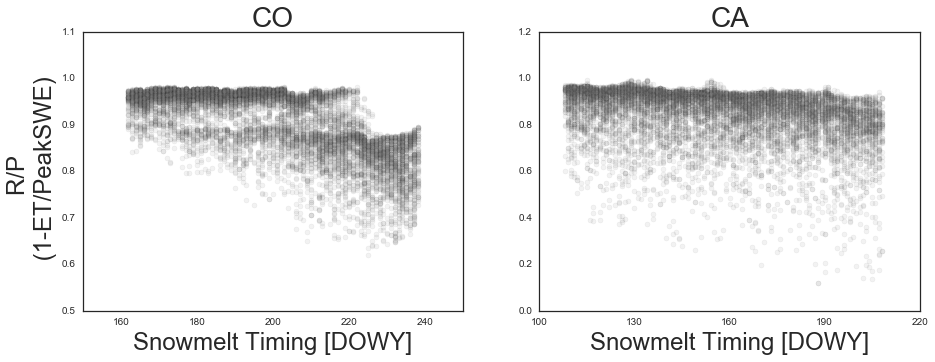

In [18]:
y = 'ablRR_ET'
ylab = 'R/P \n (1-ET/PeakSWE)'
x = 'TpeakSWE'
xlab = 'Snowmelt Timing [DOWY]'
#c = 'PeakSWE'
#clab = 'Snowmelt Timing [DOWY]'
s = 25
cmap='Reds'
xmin = -200
xmax = 1600
vmin = 0
vmax = 1600
ymin = 0.4
ymax = 1.0
axfont = 24
titlefont = 28

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
df = Nr1
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
#ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
ax.scatter(df.loc[df.combo == 6,x],df.loc[df.combo == 6,y],s=s, c = '0.5',alpha=0.1)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_ylabel(ylab,fontsize=axfont)
ax.set_title('CO',fontsize=titlefont)
#ax.set_xticks(np.linspace(50,650,num=5,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
#[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(122)
df = P301
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
#ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
ax.scatter(df.loc[df.combo == 6,x],df.loc[df.combo == 6,y],s=s, c = '0.5',alpha=0.1)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_title('CA',fontsize=titlefont)
ax.set_xticks(np.linspace(100,220,num=5,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
#[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

#plt.tight_layout()
#plt.savefig('./figures/smex8_TpeakSWE_ablRR_ET.png',dpi=300,bbox_inches='tight')

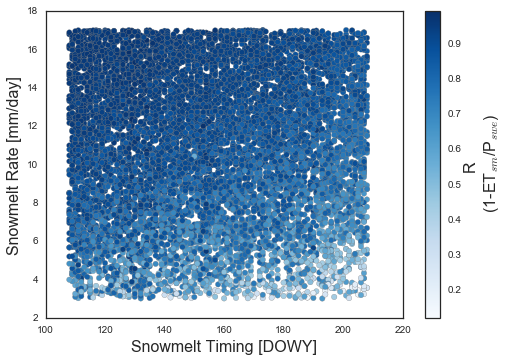

In [19]:
df = P301
df = df.loc[df.combo == 6]

plt.scatter(df.TpeakSWE,df.SMR,s=30,c=df.ablRR_ET,cmap='Blues',edgecolor='0.5')
plt.ylabel('Snowmelt Rate [mm/day]', fontsize=16)
plt.xlabel('Snowmelt Timing [DOWY]', fontsize=16)
cb = plt.colorbar()
cb.set_label(label='R \n (1-ET$_{sm}$/P$_{swe}$)', fontsize=16)

In [20]:
def plt_smr_smt_grid(x,y,z,npts,nc,cmap,axfont,labels,ylab,xlab,clab):
    '''x = x axis variable
    y = y axis variable
    z = z axis variable
    npts = number of interpolation points along a side
nc = number of contour levels
cmap = colormap
axfont = axis font size
labels = titles
ylab = ylabel
xlab = xlabel
'''
    
    #smts = [201,143] # snow melt times [DOWY]
    #smrs = [11.6,0.007467*1000] # snow melt rates
    smts = [200,158] # snow melt times [DOWY], from scenario generating scripts
    smrs = [10.05, 11.45] # snow melt rates [mm/day] from scenario generating scripts
    
    dfs = [Nr1,P301]
        
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    
    axes = [ax1,ax2]
    
    # Now add the colorbar
    cbax1 = fig.add_axes([0.125, -0.04, 0.225, 0.03])
    cbax2 = fig.add_axes([0.4, -0.04, 0.225, 0.03])
    #cbaxes = fig.add_axes([0.15, 0.3, 0.8, 0.1]) 
    
    
    cbaxes = [cbax1,cbax2]
    
    ct = 0
    
    vmins = []
    vmaxs = []
    
    for df in [Nr1,P301]:
        vmins.append(df[z].min())
        vmaxs.append(df[z].max())
    
    vmin = np.min(vmins)
    vmax = np.max(vmaxs)
    print vmin
    print vmax
    
    #cl = np.linspace(vmin,vmax,nc)
    
    for df,ax,label,cbax,smt,smr in zip(dfs,axes,labels,cbaxes,smts,smrs):
        df = df.loc[(df.combo == 6) & (df.ablRR_ET>=0)]
        
        ymin = df[y].min()
        ymax = df[y].max()
        xmin = df[x].min()
        xmax = df[x].max()
        
        zmin = df[z].min()
        zmax = df[z].max()
        
        cl = np.linspace(zmin,zmax,nc)
        
        xi = np.linspace(xmin,xmax,npts) # create the grid
        yi = np.linspace(ymin,ymax,npts)
        
        zi = griddata((df[x], df[y]), df[z], (xi[None,:], yi[:,None]), method='linear') # interpolate
        
        #Cl = ax.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k',levels=contour_levels)
        Cf = ax.contourf(xi,yi,zi,cl,levels=cl,cmap=cmap)
        
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(xmin,xmax)
        
        [tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
        [tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
        
        ax.set_title(label,fontsize = axfont+2)
        if ct ==0:
            ax.set_ylabel(ylab,fontsize=axfont+2)
            
        ax.set_xlabel(xlab, fontsize=axfont+2)
        ax.plot(smt,smr,'*w',ms=25)
        ax.plot(smt,smr,'*k',ms=15)
        cb = plt.colorbar(Cf,cax = cbax,orientation='horizontal',format='%0.2f')
        cb.set_label(clab, fontsize=axfont-2)
        ct += 1
    
    #cb = plt.colorbar(Cf,cax = cbaxes,orientation='horizontal',format='%0.2f') 
    #cb.set_label('R\n(1-ET$_{sm}$/P$_{swe}$)', fontsize=14)

0.00141735390352
1.0


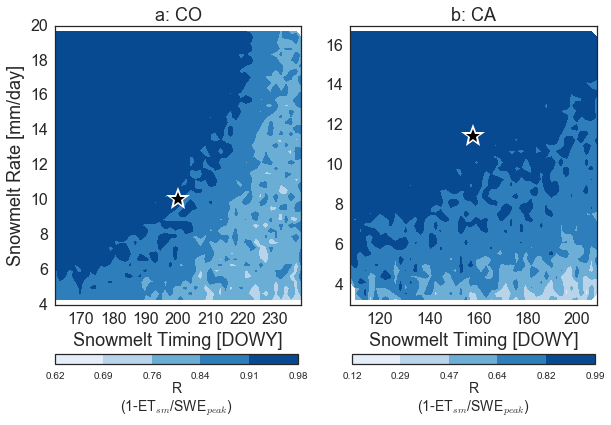

In [23]:
plt_smr_smt_grid('TpeakSWE','SMR','ablRR_ET',50,6,'Blues',16,['a: CO','b: CA'],
                 'Snowmelt Rate [mm/day]','Snowmelt Timing [DOWY]',
                 'R\n(1-ET$_{sm}$/SWE$_{peak}$)')
#plt.savefig('./figures/TpeakSWE_SMR_interp_sen8.png',dpi=300,bbox_inches='tight')
#plt.savefig('./figures/TpeakSWE_SMR_interp_sen8.pdf',bbox_inches='tight')

-358.864393424
1303.34557598


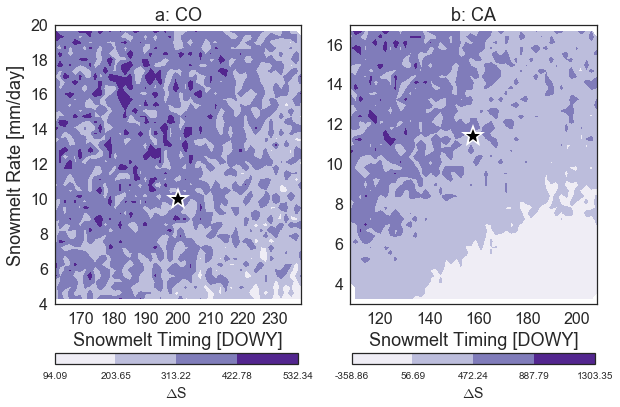

In [34]:
plt_smr_smt_grid('TpeakSWE','SMR','wb',50,5,'Purples',16,['a: CO','b: CA','c: NM'],
                 'Snowmelt Rate [mm/day]','Snowmelt Timing [DOWY]',
                 '$\Delta$S')
plt.savefig('./figures/TpeakSWE_wb_interp_sen8.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/TpeakSWE_wb_interp_sen8.pdf',bbox_inches='tight')

In [25]:
Nr1['gwStore2'] = standardize(Nr1.gwStore)
P301['gwStore2'] = standardize(P301.gwStore)

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [42]:
def set_varID(var):
    if var=='multi_SMR_coef':
        return 1
    if var=='multi_TpeakSWE_coef':
        return 2
    if var=='multi_mod_r2':
        return 3

In [43]:
def fix_site(site):
    if site=='Nr1':
        return 'CO'
    if site == 'Vcm':
        return 'NM'
    if site == 'P301':
        return 'CA'

In [44]:
#tmp = soils.loc[soils.combo=='d3:s3',['multi_SMR_coef','multi_TpeakSWE_coef','multi_PeakSWE_coef','Site']]
tmp = soils.loc[soils.idx==6,['multi_SMR_coef','multi_TpeakSWE_coef','multi_mod_r2','Site','multi_mod_pval']]

In [45]:
tmp.multi_SMR_coef = tmp.multi_SMR_coef.round(2)
tmp.multi_TpeakSWE_coef = tmp.multi_TpeakSWE_coef.round(2)
tmp.multi_mod_r2 = tmp.multi_mod_r2.round(2)

In [46]:
df = pd.melt(tmp,id_vars='Site')

In [47]:
df['varID'] = df.variable.map(set_varID)
df['Site'] = df.Site.map(fix_site)

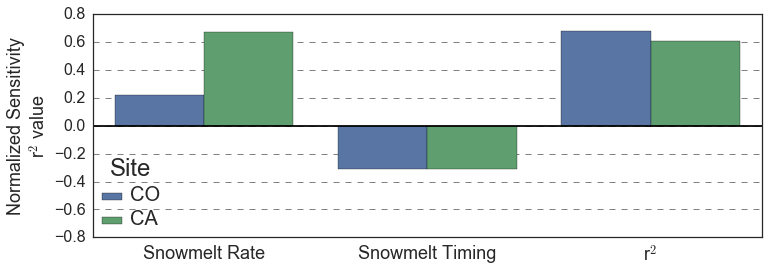

In [48]:
plt.figure(figsize=(12,4))
p = sns.barplot(x='varID', y='value',data=df,hue='Site')
p.set_xticklabels(['Snowmelt Rate','Snowmelt Timing','r$^2$'], fontsize=18)
p.set_xlabel('')
p.set_ylabel('Normalized Sensitivity\nr$^2$ value', fontsize = 18)
[tick.label.set_fontsize(16) for tick in p.yaxis.get_major_ticks()];
#plt.title('Melt Season', fontsize = 16)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()  # all the text.Text instance in the legend
ttext = leg.get_title()
plt.ylim(-0.8,0.8)
plt.axhline(0,c='k')
plt.grid(b=True, which='major', axis = 'y' ,color='0.5', linestyle='--')

plt.setp(ltext,fontsize=20)
plt.setp(ttext,fontsize=24)
plt.savefig('./figures/melt_season_coef_comparision_sen8.png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/melt_season_coef_comparision_sen8.pdf', bbox_inches='tight')

In [37]:
df

,Site,variable,value,varID
0,CO,multi_SMR_coef,0.22,1.0
1,CA,multi_SMR_coef,0.67,1.0
2,CO,multi_TpeakSWE_coef,-0.31,2.0
3,CA,multi_TpeakSWE_coef,-0.31,2.0
4,CO,multi_mod_r2,0.68,3.0
5,CA,multi_mod_r2,0.61,3.0
6,CO,multi_mod_pval,0.00,NaN
7,CA,multi_mod_pval,0.00,NaN


In [36]:
tmp = soils.loc[soils.idx==6,['wb_SMR_coef','wb_TpeakSWE_coef','wb_r2','Site','wb_pval']]

In [37]:
df = pd.melt(tmp,id_vars='Site')

In [38]:
def set_varID(var):
    if var=='wb_SMR_coef':
        return 1
    if var=='wb_TpeakSWE_coef':
        return 2
    if var=='wb_r2':
        return 3

In [39]:
df['varID'] = df.variable.map(set_varID)
df['Site'] = df.Site.map(fix_site)

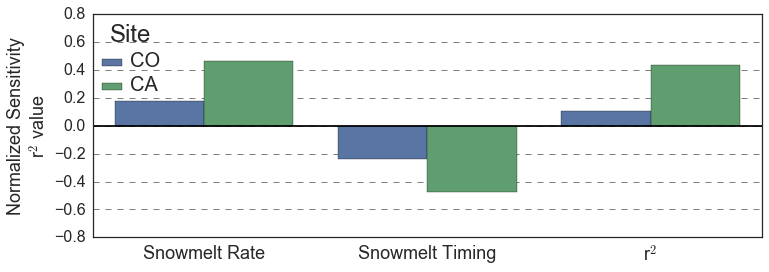

In [41]:
plt.figure(figsize=(12,4))
p = sns.barplot(x='varID', y='value',data=df,hue='Site')
p.set_xticklabels(['Snowmelt Rate','Snowmelt Timing','r$^2$'], fontsize=18)
p.set_xlabel('')
p.set_ylabel('Normalized Sensitivity\nr$^2$ value', fontsize = 18)
[tick.label.set_fontsize(16) for tick in p.yaxis.get_major_ticks()];
#plt.title('Melt Season', fontsize = 16)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()  # all the text.Text instance in the legend
ttext = leg.get_title()
plt.ylim(-0.8,0.8)
plt.axhline(0,c='k')
plt.grid(b=True, which='major', axis = 'y' ,color='0.5', linestyle='--')

plt.setp(ltext,fontsize=20)
plt.setp(ttext,fontsize=24)
plt.savefig('./figures/melt_season_wb_closure_coefficients_sen8.png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/melt_season_wb_closure_coefficients_sen8.pdf', bbox_inches='tight')

In [43]:
df

,Site,variable,value,varID
0,CO,wb_SMR_coef,1.759248e-01,1.0
1,CA,wb_SMR_coef,4.660380e-01,1.0
2,CO,wb_TpeakSWE_coef,-2.383681e-01,2.0
3,CA,wb_TpeakSWE_coef,-4.743053e-01,2.0
4,CO,wb_r2,1.045788e-01,3.0
5,CA,wb_r2,4.341141e-01,3.0
6,CO,wb_pval,1.617755e-240,NaN
7,CA,wb_pval,0.000000e+00,NaN


In [44]:
combos = data.combo.unique()

In [45]:
soils['intercept'] = np.NaN
soils['SMR_coef'] = np.NaN
soils['TpeakSWE_coef'] = np.NaN
soils['PeakSWE_coef'] = np.NaN
soils['mod_r2'] = np.NaN

In [46]:
for combo in combos:
    mod = sm.ols('RR_ET2 ~ SMR2 + TpeakSWE2 + PeakSWE2 + 1',Nr1.loc[data.combo==combo]).fit()
    soils.loc[soils.combo==combo,'intercept'] = mod.params['Intercept']
    soils.loc[soils.combo==combo,'SMR_coef'] = mod.params['SMR2']
    soils.loc[soils.combo==combo,'TpeakSWE_coef'] = mod.params['TpeakSWE2']
    soils.loc[soils.combo==combo,'PeakSWE_coef'] = mod.params['PeakSWE2']
    soils.loc[soils.combo==combo,'mod_r2'] = mod.rsquared

AttributeError: 'DataFrame' object has no attribute 'combo'

In [47]:
soils[['TpeakSWE_coef','SMR_coef','PeakSWE_coef','mod_r2']].describe()

/Users/barnhatb/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,TpeakSWE_coef,SMR_coef,PeakSWE_coef,mod_r2
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [48]:
df = Vcm
mod_SMR =  mod = sm.ols('ablRR_ET ~ SMR + TpeakSWE +1',df.loc[df.combo=='d3:s3']).fit()
print mod_SMR.summary()

NameError: name 'Vcm' is not defined

In [49]:
df = P301
mod_SMR =  mod = sm.ols('ablRR_ET2 ~ SMR2 + TpeakSWE2 +1',df.loc[df.combo=='d3:s3']).fit()
print mod_SMR.summary()

/Users/barnhatb/anaconda/lib/python2.7/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

## Compare Sites with Different Rooting Depths

In [52]:
df = soils[['PAWS','Site','multi_SMR_coef','multi_TpeakSWE_coef']]
df = pd.melt(df,value_vars=['multi_SMR_coef','multi_TpeakSWE_coef'],id_vars=['PAWS','Site'])

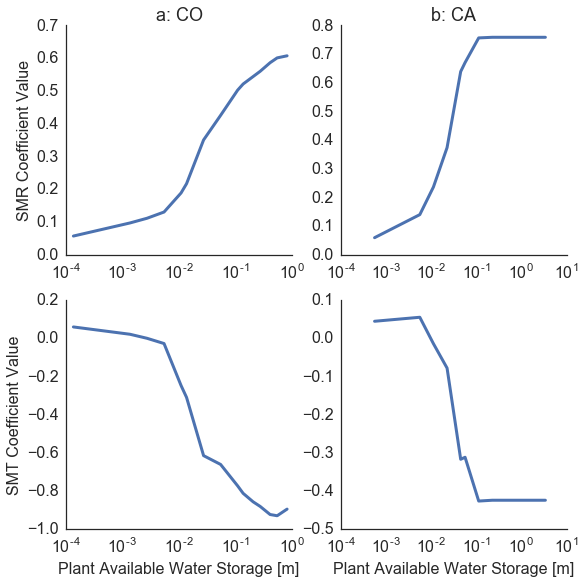

In [56]:
g = sns.FacetGrid(df,row='variable',col='Site',sharex=False,sharey=False,size=4)
f = g.map(plt.semilogx,'PAWS','value',lw=3)

f.axes[0][0].set_title("a: CO", fontsize=18)
f.axes[0][1].set_title("b: CA", fontsize=18)
f.axes[1][0].set_title(" ", fontsize=18)
f.axes[1][1].set_title(" ", fontsize=18)
f.axes[0][0].set_ylabel('SMR Coefficient Value', fontsize = 16)
f.axes[1][0].set_ylabel('SMT Coefficient Value', fontsize = 16)
f.axes[1][0].set_xlabel('Plant Available Water Storage [m]', fontsize = 16)
f.axes[1][1].set_xlabel('Plant Available Water Storage [m]', fontsize = 16)

for i in [0,1]:
    for j in [0,1]:
        [tick.label.set_fontsize(16) for tick in f.axes[i][j].yaxis.get_major_ticks()];
        [tick.label.set_fontsize(16) for tick in f.axes[i][j].xaxis.get_major_ticks()];
        
plt.savefig('./figures/model_coef_rooting_depth_sen8.png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/model_coef_rooting_depth_sen8.pdf', bbox_inches='tight')